In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Clim_data/df_eddies_processed.pkl')
with open('/srv/scratch/z5297792/Clim_data/Sample_Data/dic_sample_vert_info.pkl', 'rb') as f:
    dic_sample = pickle.load(f)
sample_eddies = [8, 896, 2504, 2749, 382, 926, 1394, 1967]

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, smooth, rossby_number



In [2]:
df_eddies


,Day,ID,Cyc,Lon,Lat,ic,jc,x0,y0,q11,q12,q22,w,Age,fname
0,1462,1,CE,161.093546,-29.714998,261,275,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.000011,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1463,1,CE,160.871720,-29.764770,258,273,910.409810,1346.368459,-0.006279,0.001039,-0.002655,-0.000018,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1464,1,CE,160.922307,-29.791470,259,272,915.918179,1345.231552,-0.003853,0.000654,-0.002549,-0.000013,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1465,1,CE,160.955011,-29.644446,259,276,914.513286,1361.918280,-0.004816,0.001225,-0.003001,-0.000016,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1466,1,CE,160.900960,-29.634113,258,276,909.171353,1361.201101,-0.003874,0.001326,-0.003299,-0.000014,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132634,10646,2962,CE,155.090978,-40.102161,223,14,708.322310,67.634123,-0.002455,-0.000032,-0.001645,-0.000008,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132635,10647,2962,CE,154.836115,-40.385267,220,6,695.611882,30.128608,-0.001272,0.000185,-0.001351,-0.000005,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132636,10648,2962,CE,154.979715,-40.569836,223,3,712.690769,14.777712,-0.001122,0.000260,-0.001881,-0.000006,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132637,10649,2962,CE,155.150873,-40.263961,224,11,717.914731,52.244946,-0.001737,-0.000091,-0.001655,-0.000007,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [3]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

res = 1  # 1 km resolution
x_new = np.arange(0, x_grid[-1], res)
y_new = np.arange(0, y_grid[-1], res)
X_new, Y_new = np.meshgrid(x_new, y_new, indexing='ij')
new_points = np.column_stack((X_new.ravel(), Y_new.ravel()))

interp_lon = RegularGridInterpolator((x_grid, y_grid), lon_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)
interp_lat = RegularGridInterpolator((x_grid, y_grid), lat_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)

lon_new = interp_lon(new_points).reshape(len(x_new), len(y_new))
lat_new = interp_lat(new_points).reshape(len(x_new), len(y_new))


#### Side Profiles

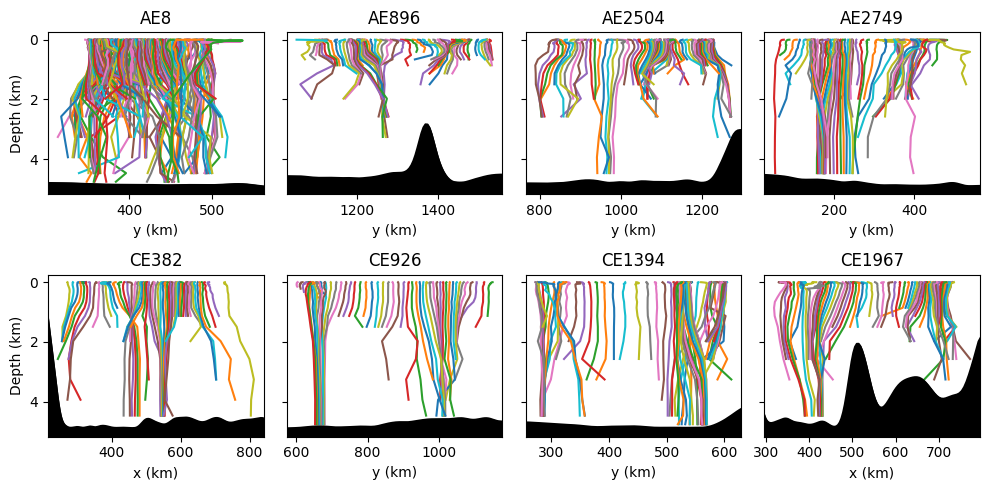

In [4]:
fig, axs = plt.subplots(2, 4, figsize=(10,5), sharey=True)
df_means = pd.DataFrame([
    {
        'Eddy': eddy,
        'x_mean': df_all['x'].mean(),
        'y_mean': df_all['y'].mean()
    }
    for eddy, days in dic_sample.items()
    for df_all in [pd.concat(
        [df0 for df0 in days.values() 
         if not df0.empty and not df0.isna().all().all()],
        ignore_index=True
    )]
])

for e, eddy in enumerate(dic_sample.keys()):
    ax = axs[e // 4, e % 4]
    dic = dic_sample[eddy]
    pmean = df_means[df_means['Eddy']==eddy].iloc[0]
    for d, day in enumerate(dic.keys()):
        df = dic[day].copy()
        if ('1967' in eddy) or ('382' in eddy):
            ax.plot(df['x'], -df['Depth']/1000)
            ax.set_xlabel('x (km)')
        else:
            ax.plot(df['y'], -df['Depth']/1000)
            ax.set_xlabel('y (km)')
    xlim = ax.get_xlim()
    
    if ('1967' in eddy) or ('382' in eddy):
        jc = np.where(np.abs(pmean['y_mean']-y_grid)==np.min(np.abs(pmean['y_mean']-y_grid)))[0][0]
        ax.plot(x_grid, h[:, jc]/1000, 'k')
    else:
        ic = np.where(np.abs(pmean['x_mean']-x_grid)==np.min(np.abs(pmean['x_mean']-x_grid)))[0][0]
        ax.plot(y_grid, h[ic, :]/1000, 'k')

    ylim = ax.get_ylim()

    if ('1967' in eddy) or ('382' in eddy):
        jc = np.where(np.abs(pmean['y_mean'] - y_grid) == np.min(np.abs(pmean['y_mean'] - y_grid)))[0][0]
        ax.fill_between(x_grid, h[:, jc] / 1000, 10, color='k')
    else:
        ic = np.where(np.abs(pmean['x_mean'] - x_grid) == np.min(np.abs(pmean['x_mean'] - x_grid)))[0][0]
        ax.fill_between(y_grid, h[ic, :] / 1000, 10, color='k')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
            
    cyc = df_eddies[df_eddies['ID']==int(eddy[4:])].iloc[0]['Cyc']
    ax.set_title(f'{cyc}{eddy[4:]}')
    if e % 4 == 0:
        ax.set_ylabel('Depth (km)')
axs[0,0].invert_yaxis()

# for ax in axs.flat:
#     xmin, xmax = ax.get_xlim()
#     ax.set_xticks(np.arange(np.floor(xmin / 100) * 100, np.ceil(xmax / 100) * 100 + 1, 100))

plt.tight_layout()


#### Depths

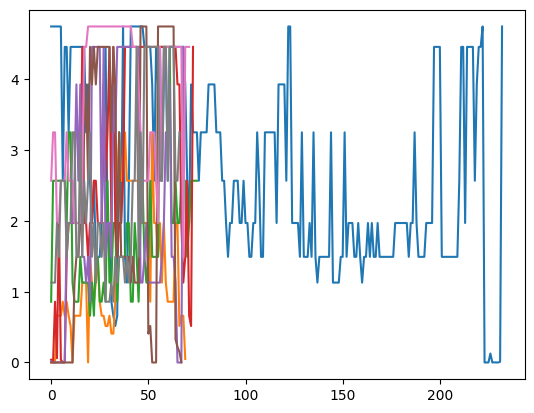

In [5]:
for e, eddy in enumerate(dic_sample.keys()):
    dic = dic_sample[eddy]
    depths = []
    for d, day in enumerate(dic.keys()):
        df = dic[day].copy()
        if len(df):
            depths.append(-df.iloc[-1]['Depth']/1000)
        else:
            depths.append(0)
    plt.plot(depths)


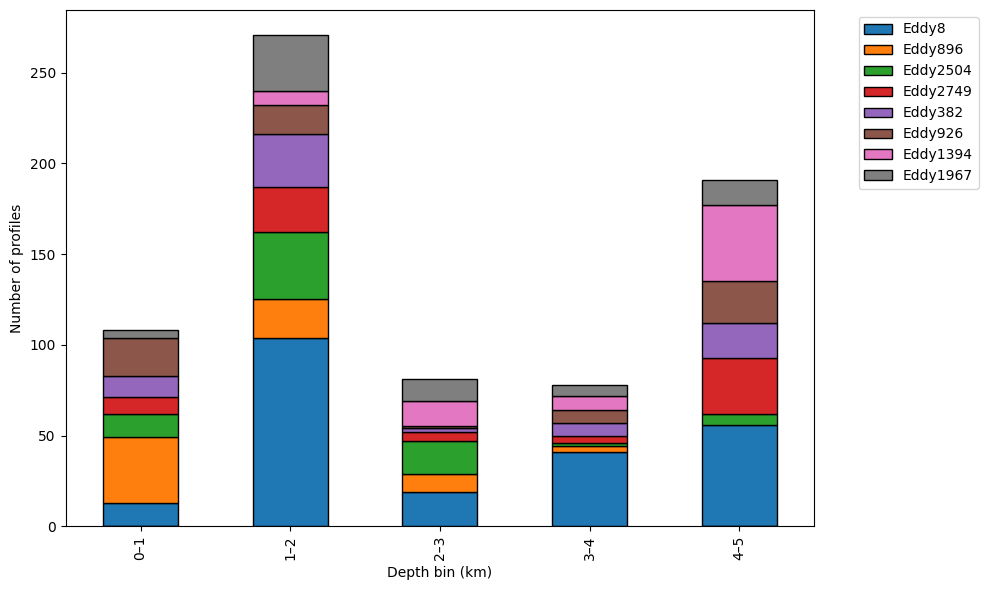

In [6]:
# Adjustable bin width
bin_width = 1  # km
max_depth_km = 5  # adjust as needed

# Create bin edges and labels
bins = np.arange(0, max_depth_km + bin_width, bin_width)
bin_labels = [f"{round(b,1)}–{round(b+bin_width,1)}" for b in bins[:-1]]

# Prepare DataFrame
eddy_names = list(dic_sample.keys())
bin_counts = pd.DataFrame(0, index=bin_labels, columns=eddy_names)

# Fill in counts
for eddy in eddy_names:
    dic = dic_sample[eddy]
    depths = []
    for day in dic:
        df = dic[day].copy()
        if len(df):
            depth_km = -df.iloc[-1]['Depth'] / 1000
            depths.append(depth_km)
        else:
            depths.append(0)

    counts, _ = np.histogram(depths, bins=bins)
    bin_counts.loc[:, eddy] = counts

# Plot
bin_counts.plot(kind='bar', stacked=True, figsize=(10, 6), edgecolor='black')
plt.xlabel('Depth bin (km)')
plt.ylabel('Number of profiles')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Ellipticity

##### Depth

In [7]:
df_means = pd.DataFrame([
    {
        'Eddy': eddy,
        'x_mean': df_all['x'].mean(),
        'y_mean': df_all['y'].mean()
    }
    for eddy, days in dic_sample.items()
    for df_all in [pd.concat(
        [df0 for df0 in days.values() 
         if not df0.empty and not df0.isna().all().all()],
        ignore_index=True
    )]
])


In [8]:
for eddy in sample_eddies:
    eddy = f'Eddy{eddy}'
    
    dic = dic_sample[eddy]

    for day in dic.keys():
        df = dic[day]

        if len(df):

            Qs = df['Q'].values.copy()
            Rcs = df['Rc'].values.copy()
            psi0s = df['psi0'].values.copy()
            Ros = df['Ro'].values.copy()
            depths = -df['Depth'].values.copy() / 1000  # in km
            
            # smooth against frame index t
            window = 50
            sq11  = smooth([q[0,0] for q in Qs], depths, num=1000, window=window)
            sq12  = smooth([q[0,1] for q in Qs], depths, num=1000, window=window)
            sq22  = smooth([q[1,1] for q in Qs], depths, num=1000, window=window)
    
            df['sw'] = 2 * (sq11 + sq22)
            df['sQ'] = [np.array([[sq11[i], sq12[i]], [sq12[i], sq22[i]]]) for i in range(len(sq11))]
            
            df['sRc']   = smooth(Rcs,                    depths, window=window)
            df['spsi0'] = smooth(psi0s,                  depths, window=window)
    
            df['sRo']   = smooth(Ros,                    depths, window=window)
            


/home/z5297792/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/z5297792/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/z5297792/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/z5297792/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/z5297792/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/z5297792/.local/lib/python3.10/site-pac

In [9]:
sample_eddies

[8, 896, 2504, 2749, 382, 926, 1394, 1967]

In [10]:
eddy = 8
k = 90

df = dic_sample[f'Eddy{eddy}'][list(dic_sample[f'Eddy{eddy}'].keys())[k]]
df.head()


,x,y,Q,w,Rc,psi0,Ro,z,Depth,TD,sw,sQ,sRc,spsi0,sRo
0,274.183577,385.520618,"[[0.011157307652045628, 0.003822914919299331],...",0.000044,80.905648,-336.356289,0.704076,0,-1.783320,0.000000,0.043893,"[[0.01106797794236652, 0.0038012851722417605],...",79.914849,-305.559341,0.730695
1,275.660449,384.789787,"[[0.011112734304794923, 0.003880654186670938],...",0.000044,80.906342,-253.412196,0.722062,1,-5.879627,1.647806,0.043876,"[[0.011064176440445352, 0.0038061898296377233]...",79.799392,-305.577746,0.731295
2,276.273699,384.474853,"[[0.011091739140629725, 0.003706644105433795],...",0.000044,80.903724,-367.944247,0.728074,2,-10.725783,2.337142,0.043858,"[[0.011059495210160314, 0.0038120273824514147]...",79.622255,-305.652214,0.731945
3,276.593032,384.422861,"[[0.011084002415968627, 0.003744840631220134],...",0.000044,80.903340,-307.682852,0.728996,3,-16.383097,2.647743,0.043838,"[[0.01105329306091497, 0.003819741852799673], ...",79.392737,-305.721672,0.732668
4,276.868843,384.276346,"[[0.011078557973086024, 0.003774519492091156],...",0.000044,79.669564,-277.550659,0.732717,4,-22.925581,2.959538,0.043815,"[[0.011044218795830212, 0.0038313921606792237]...",79.143890,-305.633915,0.733523


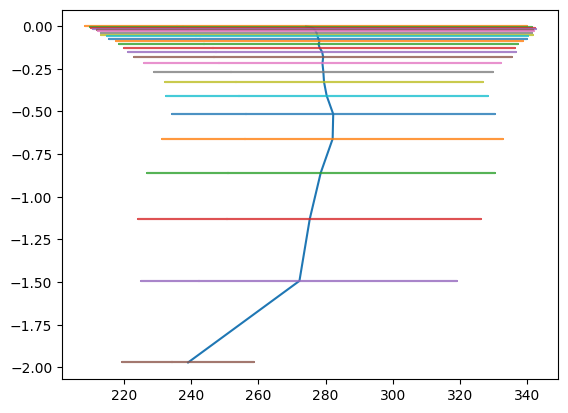

In [11]:
plt.plot(df.x, df.Depth/1000)
for x0, y0, Qm, Rc, z0 in zip(df.x, df.y, df.Q, df.Rc, df.Depth/1000):
    xe, ye = plot_ellipse(Qm, (x0, y0), scale=Rc)
    ze = np.full_like(xe, z0)
    plt.plot(xe, ze, alpha=0.8)
    

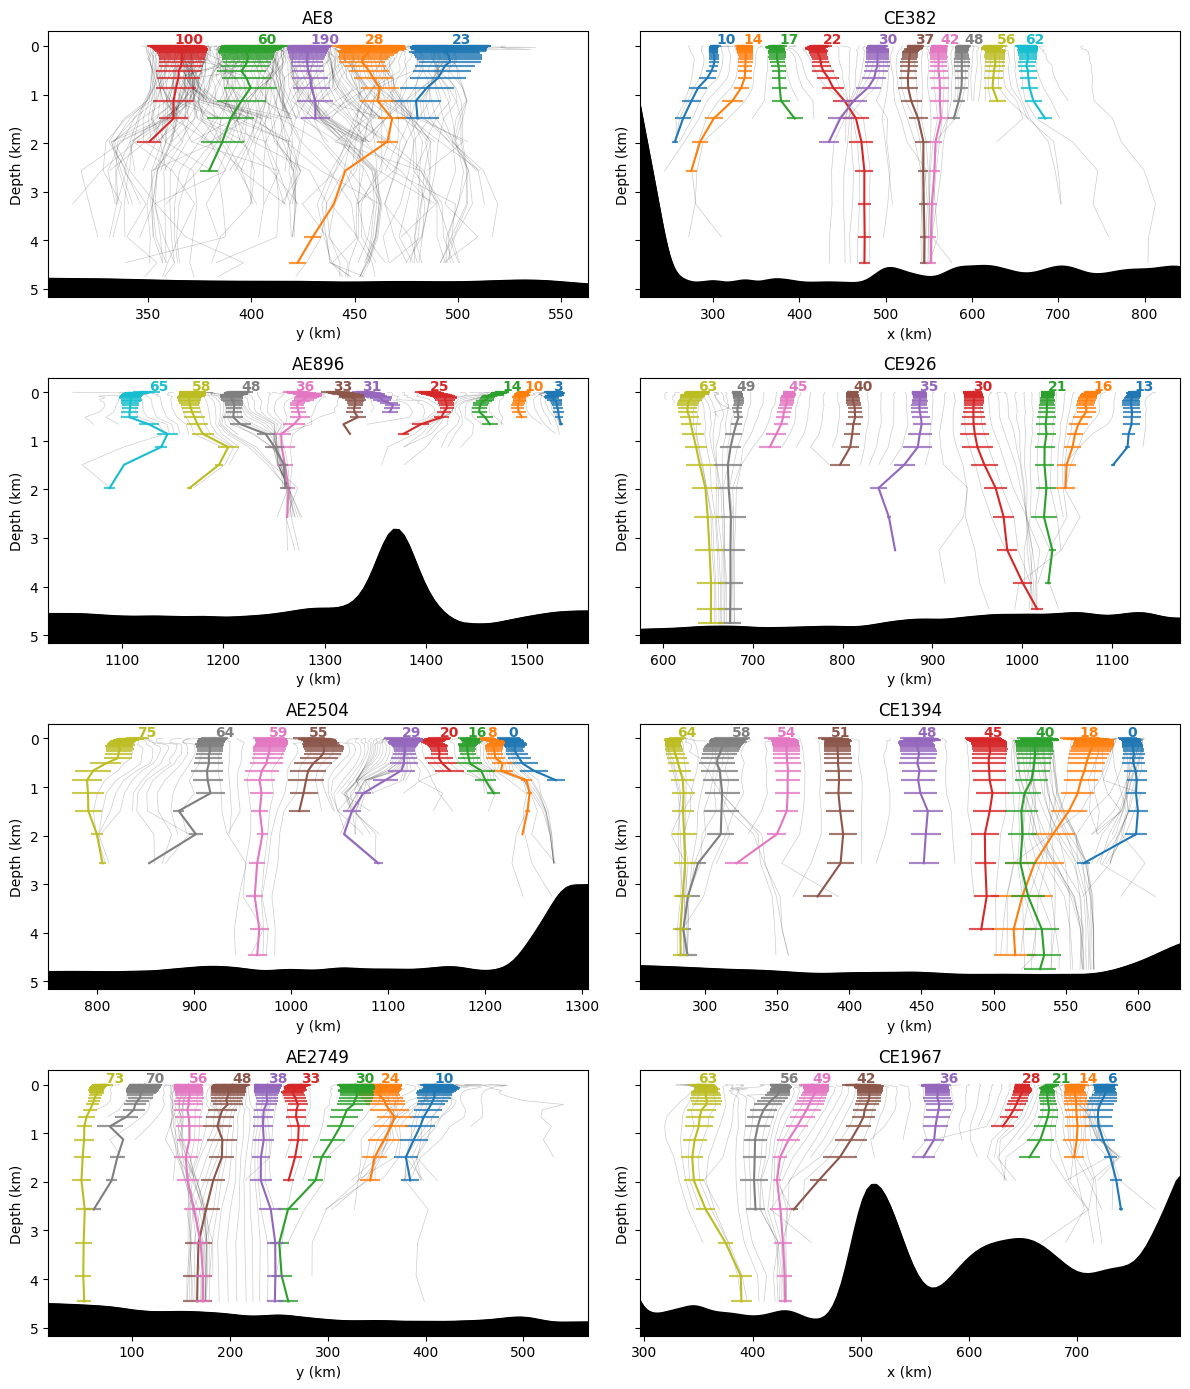

In [12]:
fig, axs = plt.subplots(4, 2, figsize=(12,14), sharey=True)

eddy_p = sample_eddies

days_p = [[23, 28, 60, 100, 190],
          [3, 10, 14, 25, 31, 33, 36, 48, 58, 65],
          [0,  8, 16, 20, 29, 55, 59, 64, 75],
          [10, 24, 30, 33, 38, 48, 56, 70, 73],
          [10, 14, 17, 22, 30, 37, 42, 48, 56, 62],
          [13, 16, 21, 30, 35, 40, 45, 49, 63],
          [0, 18, 40, 45, 48, 51, 54, 58, 64],
          [6, 14, 21, 28, 36, 42, 49, 56, 63]]
          
for e, (eddy, days) in enumerate(zip(eddy_p, days_p)):

    ax = axs[e % 4, e // 4]

    eddy = f'Eddy{eddy}'
    
    pmean = df_means[df_means['Eddy']==eddy].iloc[0]
    
    dic = dic_sample[eddy]

    for day in dic.keys():
        if int(day[3:]) not in days:
            df = dic[day].copy()
            if ('1967' in eddy) or ('382' in eddy):
                ax.plot(df.x, -df.Depth/1000, linewidth=.5, color='k', alpha=.2)
            else:
                ax.plot(df.y, -df.Depth/1000, linewidth=.5, color='k', alpha=.2)
    
    colors = plt.get_cmap('tab10').colors
    for d, day_idx in enumerate(days):
        
        day_key = list(dic_sample[eddy].keys())[day_idx]
        df = dic[day_key].copy()
    
        if len(df):
            
            # raw data
            xs = df['x'].values.copy()
            ys = df['y'].values.copy()
            sQs = df['sQ'].values.copy()
            sq11 = [q[0,0] for q in sQs]
            sq12 = [q[0,1] for q in sQs]
            sq22 = [q[1,1] for q in sQs]
            sRc = df['sRc'].values.copy()
            spsi0 = df['spsi0'].values.copy()
            Ros = df['Ro'].values.copy()
            depths = -df['Depth'].values.copy() / 1000  # in km

            # plot each smoothed ellipse at its depth
            if ('1967' in eddy) or ('382' in eddy):
                ax.plot(xs, depths, color=colors[d % 10], label=day_idx)
                ax.text(xs[0], -.05, day_idx, color=colors[d % 10], fontweight='bold')
            else:
                ax.plot(ys, depths, color=colors[d % 10], label=day_idx)
                ax.text(ys[0], -.05, day_idx, color=colors[d % 10], fontweight='bold')
            for x0, y0, q11, q12, q22, Rc, z0 in zip(xs, ys, sq11, sq12, sq22, sRc, depths):
                Qm = np.array([[q11, q12],[q12, q22]])
                xe, ye = plot_ellipse(Qm, (x0, y0), scale=Rc/5)
                ze = np.full_like(xe, z0)
                if ('1967' in eddy) or ('382' in eddy):
                    ax.plot(xe, ze, color=colors[d % 10], alpha=0.8)
                else:
                    ax.plot(ye, ze, color=colors[d % 10], alpha=0.8)

    xlim = ax.get_xlim()
    
    if ('1967' in eddy) or ('382' in eddy):
        jc = np.where(np.abs(pmean['y_mean']-y_grid)==np.min(np.abs(pmean['y_mean']-y_grid)))[0][0]
        ax.plot(x_grid, h[:, jc]/1000, 'k', )
    else:
        ic = np.where(np.abs(pmean['x_mean']-x_grid)==np.min(np.abs(pmean['x_mean']-x_grid)))[0][0]
        ax.plot(y_grid, h[ic, :]/1000, 'k')
    
    ylim = ax.get_ylim()
    
    if ('1967' in eddy) or ('382' in eddy):
        jc = np.where(np.abs(pmean['y_mean'] - y_grid) == np.min(np.abs(pmean['y_mean'] - y_grid)))[0][0]
        ax.fill_between(x_grid, h[:, jc] / 1000, 10, color='k')
    else:
        ic = np.where(np.abs(pmean['x_mean'] - x_grid) == np.min(np.abs(pmean['x_mean'] - x_grid)))[0][0]
        ax.fill_between(y_grid, h[ic, :] / 1000, 10, color='k')
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if ('1967' in eddy) or ('382' in eddy):
        ax.set_xlabel('x (km)')
    else:
        ax.set_xlabel('y (km)')
    
    ax.set_ylabel('Depth (km)')
    cyc = df_eddies.loc[df_eddies['ID'] == int(eddy[4:]), 'Cyc'].iloc[0]
    ax.set_title(f'{cyc}{eddy[4:]}')
    # ax.legend(title='Day', loc='lower right', ncol=2)
    
axs[0,0].invert_yaxis()
axs[0,0].set_ylim(None, -.3)
    
plt.tight_layout()
plt.show()
    

In [13]:
df_eddies[df_eddies.ID==382].iloc[68]

Day                                                   2736
ID                                                     382
Cyc                                                     CE
Lon                                              156.62117
Lat                                             -36.213685
ic                                                     225
jc                                                     107
x0                                              722.795947
y0                                              525.801764
q11                                              -0.002406
q12                                              -0.001851
q22                                              -0.007856
w                                                -0.000021
Age                                                     69
fname    /srv/scratch/z3533156/26year_BRAN2020/outer_av...
Name: 17929, dtype: object

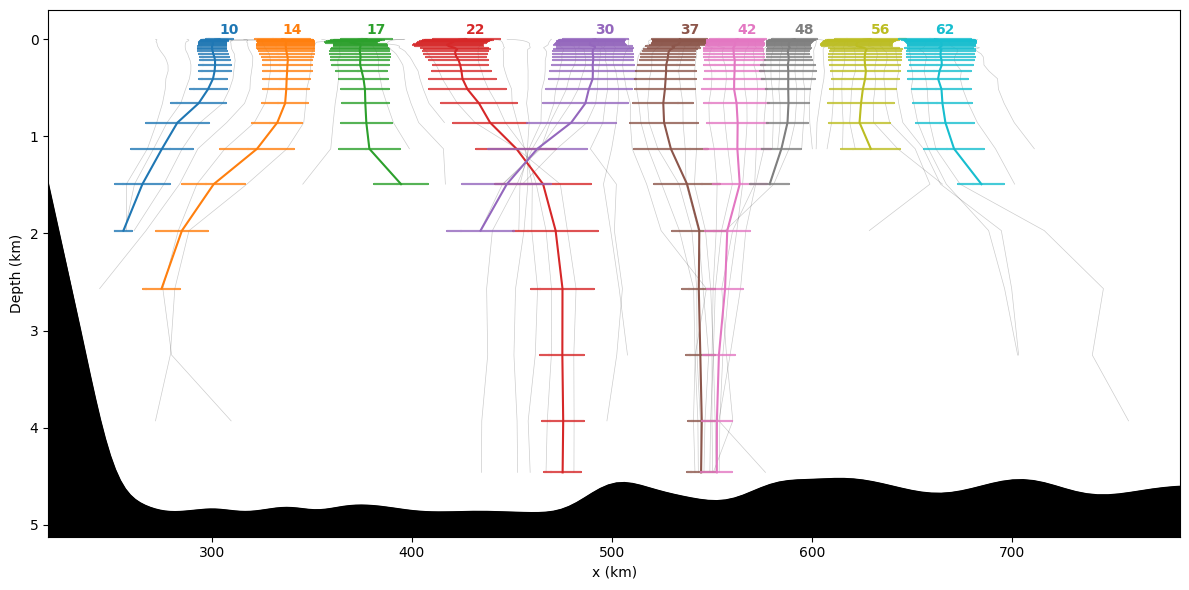

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(12,6), sharey=True)

# eddy_p = [sample_eddies[0], sample_eddies[4]]

# days_p = [[23, 28, 60, 100, 190],
#           [10, 14, 17, 22, 30, 37, 42, 48, 56, 62]]

eddy_p = [sample_eddies[4]]

days_p = [
          [10, 14, 17, 22, 30, 37, 42, 48, 56, 62]]
    
for e, (eddy, days) in enumerate(zip(eddy_p, days_p)):

    ax = axs
    eddy = f'Eddy{eddy}'
    pmean = df_means[df_means['Eddy']==eddy].iloc[0]
    dic = dic_sample[eddy]

    for day in dic.keys():
        if int(day[3:]) not in days:
            if int(day[3:]) != 2736:
                df = dic[day].copy()
                if ('1967' in eddy) or ('382' in eddy):
                    ax.plot(df.x, -df.Depth/1000, linewidth=.5, color='k', alpha=.2)
                else:
                    ax.plot(df.y, -df.Depth/1000, linewidth=.5, color='k', alpha=.2)
    
    colors = plt.get_cmap('tab10').colors
    for d, day_idx in enumerate(days):
        
        day_key = list(dic_sample[eddy].keys())[day_idx]
        df = dic[day_key].copy()
    
        if len(df):
            
            # raw data
            xs = df['x'].values.copy()
            ys = df['y'].values.copy()
            sQs = df['sQ'].values.copy()
            sq11 = [q[0,0] for q in sQs]
            sq12 = [q[0,1] for q in sQs]
            sq22 = [q[1,1] for q in sQs]
            sRc = df['sRc'].values.copy()
            spsi0 = df['spsi0'].values.copy()
            Ros = df['Ro'].values.copy()
            depths = -df['Depth'].values.copy() / 1000  # in km

            # plot each smoothed ellipse at its depth
            if ('1967' in eddy) or ('382' in eddy):
                ax.plot(xs, depths, color=colors[d % 10], label=day_idx)
                ax.text(xs[0], -.05, day_idx, color=colors[d % 10], fontweight='bold')
            else:
                ax.plot(ys, depths, color=colors[d % 10], label=day_idx)
                ax.text(ys[0], -.05, day_idx, color=colors[d % 10], fontweight='bold')
            for x0, y0, q11, q12, q22, Rc, z0 in zip(xs, ys, sq11, sq12, sq22, sRc, depths):
                Qm = np.array([[q11, q12],[q12, q22]])
                xe, ye = plot_ellipse(Qm, (x0, y0), scale=Rc/3)
                ze = np.full_like(xe, z0)
                if ('1967' in eddy) or ('382' in eddy):
                    ax.plot(xe, ze, color=colors[d % 10], alpha=0.8)
                else:
                    ax.plot(ye, ze, color=colors[d % 10], alpha=0.8)

    xlim = ax.get_xlim()
    
    if ('1967' in eddy) or ('382' in eddy):
        jc = np.where(np.abs(pmean['y_mean']-y_grid)==np.min(np.abs(pmean['y_mean']-y_grid)))[0][0]
        ax.plot(x_grid, h[:, jc]/1000, 'k', )
    else:
        ic = np.where(np.abs(pmean['x_mean']-x_grid)==np.min(np.abs(pmean['x_mean']-x_grid)))[0][0]
        ax.plot(y_grid, h[ic, :]/1000, 'k')
    ylim = ax.get_ylim()
    
    if ('1967' in eddy) or ('382' in eddy):
        jc = np.where(np.abs(pmean['y_mean'] - y_grid) == np.min(np.abs(pmean['y_mean'] - y_grid)))[0][0]
        ax.fill_between(x_grid, h[:, jc] / 1000, 10, color='k')
    else:
        ic = np.where(np.abs(pmean['x_mean'] - x_grid) == np.min(np.abs(pmean['x_mean'] - x_grid)))[0][0]
        ax.fill_between(y_grid, h[ic, :] / 1000, 10, color='k')
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if ('1967' in eddy) or ('382' in eddy):
        ax.set_xlabel('x (km)')
    else:
        ax.set_xlabel('y (km)')
    
    ax.set_ylabel('Depth (km)')
    cyc = df_eddies.loc[df_eddies['ID'] == int(eddy[4:]), 'Cyc'].iloc[0]
    # ax.set_title(f'{cyc}')
    # ax.legend(title='Day', loc='lower right', ncol=2)
    
ax.invert_yaxis()
ax.set_ylim(None, -.3)
    
plt.tight_layout()
plt.show()

##### Surface

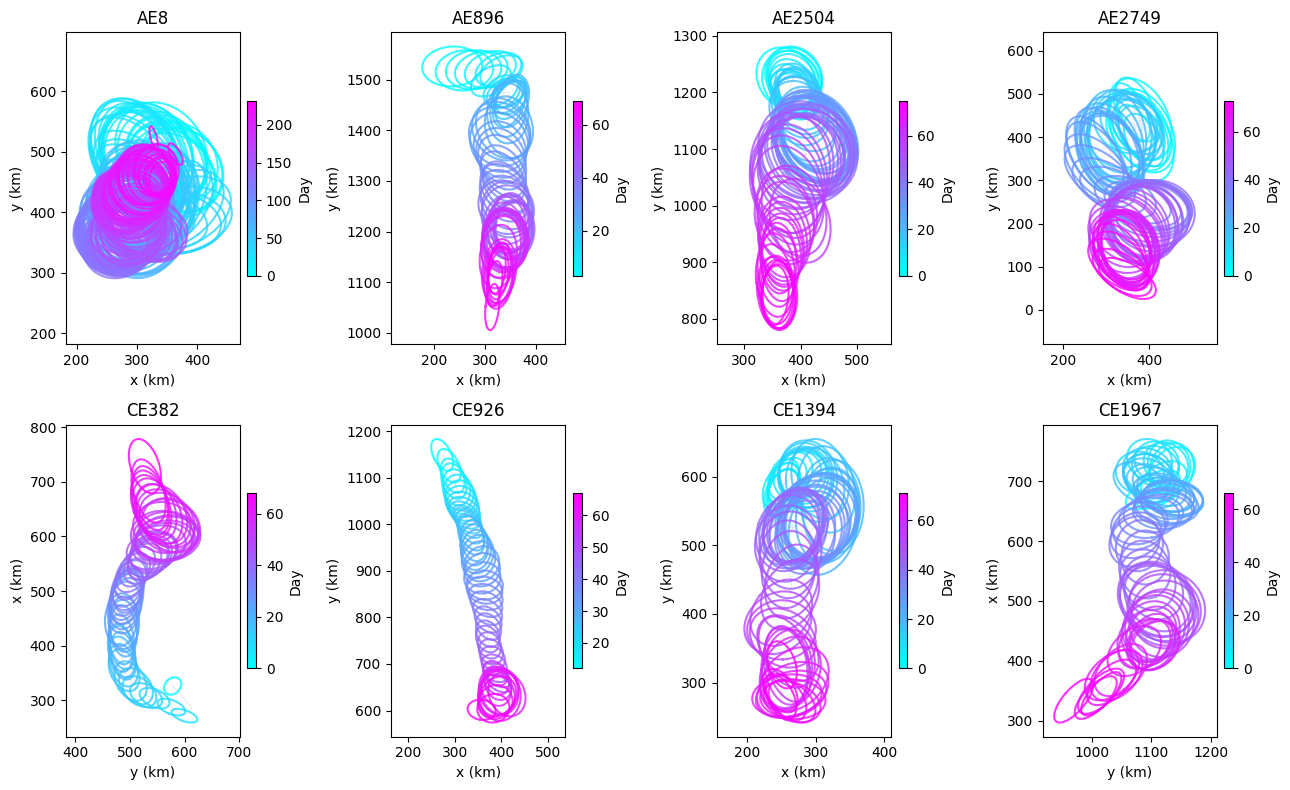

In [15]:
from matplotlib.cm import cool
from matplotlib.colors import Normalize

fig, axs = plt.subplots(2, 4, figsize=(13, 8))

for e, eddy in enumerate(dic_sample):
    ax = axs[e // 4, e % 4]
    xs, ys, Qs, Rcs, Ros, ds = [], [], [], [], [], []
    for d, day in enumerate(dic_sample[eddy]):
        df = dic_sample[eddy][day]
        if df.empty:
            continue
        xs.append(df.iloc[0]['x'])
        ys.append(df.iloc[0]['y'])

        Q = df.iloc[0]['sQ']
        if not np.any(np.isnan(Q)):
            Qs.append(np.array(Q))
        else:
            Qs.append(df.iloc[0]['Q'])

        Rc = df.iloc[0]['Rc']
        if not np.isnan(Rc):
            Rcs.append(Rc)
        else:
            Rcs.append(df.iloc[0]['sRc'])
        
        Ro = df.iloc[0]['Ro']
        if not np.isnan(Ro):
            Ros.append(Ro)
        else:
            Ros.append(df.iloc[0]['sRo'])
            
        ds.append(d)

    if not ds:
        ax.set_title(eddy)
        continue

    if ('382' in eddy) or ('1967' in eddy):
        ax.plot(ys, xs, linewidth=.5, color='lightgray', alpha=.7)
        ax.set_xlabel('y (km)')
        ax.set_ylabel('x (km)')
    else:
        ax.plot(xs, ys, linewidth=.5, color='lightgray', alpha=.7)
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')

    days = np.array(ds)
    window = 5
    sq11 = smooth([q[0,0] for q in Qs], days, num=len(days), window=window)
    sq12 = smooth([q[0,1] for q in Qs], days, num=len(days), window=window)
    sq22 = smooth([q[1,1] for q in Qs], days, num=len(days), window=window)

    sRc  = smooth(Rcs,       days, num=len(days), window=window)
    
    sRo  = smooth(Ros,       days, num=len(days), window=window)
    # sRo  = Ros

    norm = Normalize(vmin=days.min(), vmax=days.max())
    cmap = cool
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array(days)

    for xi, yi, a, b, c, scale, day in zip(xs, ys, sq11, sq12, sq22, sRc, ds):
        Qm = np.array([[a, b], [b, c]])
        xe, ye = plot_ellipse(Qm, (xi, yi), scale=scale)
        if ('382' in eddy) or ('1967' in eddy):
            ax.plot(ye, xe, color=cmap(norm(day)), alpha=.8)
        else:
            ax.plot(xe, ye, color=cmap(norm(day)), alpha=.8)

    cbar = fig.colorbar(
        sm, ax=ax,
        orientation='vertical',
        fraction=0.046,
        pad=0.04
    )
    cbar.set_label('Day')
    cbar.ax.yaxis.set_ticks_position('right')
    cbar.ax.yaxis.set_label_position('right')

    ax.axis('equal')
    cyc = df_eddies.loc[df_eddies['ID'] == int(eddy[4:]), 'Cyc'].iloc[0]
    ax.set_title(f'{cyc}{eddy[4:]}')

plt.tight_layout()
plt.show()


#### Propogation

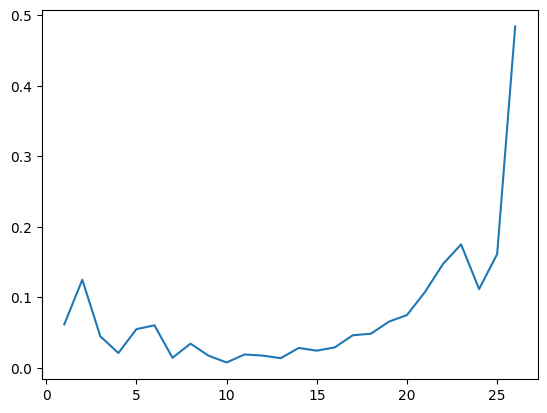

In [26]:
df = dic_sample[eddy][day]
eddy_prop = np.hypot(df.x.diff(), df.y.diff()) / 1 * 0.011574 # km/day to m/s
plt.plot(eddy_prop)


#### Eccentricity

In [30]:
# def eccentricity_from_Q(Q, definition="eccentricity"):
#     eigvals = np.linalg.eigvalsh(Q)
#     a = 1 / np.sqrt(eigvals.min())
#     b = 1 / np.sqrt(eigvals.max())
    
#     if definition == "axis_ratio":
#         return a / b
#     elif definition == "ellipticity":
#         return 1 - b / a
#     elif definition == "eccentricity":
#         return np.sqrt(1 - (b/a)**2)
#     else:
#         raise ValueError("Unknown definition")

# eccent = []
# for e, eddy in enumerate(dic_sample):
#     for d, day in enumerate(dic_sample[eddy]):
#         df = dic_sample[eddy][day]

#         eccent.extend(df.apply(
#             lambda row: eccentricity_from_Q(
#                 np.array([[np.abs(row.sQ[0,0]), row.sQ[0,1]],
#                           [row.sQ[0,1], np.abs(row.sQ[1,1])]])
#             ),
#             axis=1
#         ))

# plt.hist(eccent, bins=20, edgecolor='black')
# plt.xlabel('Eccentricity')
# plt.ylabel('Frequency')
# plt.title('Histogram of Eccentricity')
# plt.show()        

        

/scratch/pbs.6780912.kman.restech.unsw.edu.au/ipykernel_1276079/4209305795.py:3: RuntimeWarning: invalid value encountered in sqrt
  a = 1 / np.sqrt(eigvals.min())
/scratch/pbs.6780912.kman.restech.unsw.edu.au/ipykernel_1276079/4209305795.py:3: RuntimeWarning: invalid value encountered in sqrt
  a = 1 / np.sqrt(eigvals.min())
/scratch/pbs.6780912.kman.restech.unsw.edu.au/ipykernel_1276079/4209305795.py:3: RuntimeWarning: invalid value encountered in sqrt
  a = 1 / np.sqrt(eigvals.min())
/scratch/pbs.6780912.kman.restech.unsw.edu.au/ipykernel_1276079/4209305795.py:3: RuntimeWarning: invalid value encountered in sqrt
  a = 1 / np.sqrt(eigvals.min())
/scratch/pbs.6780912.kman.restech.unsw.edu.au/ipykernel_1276079/4209305795.py:3: RuntimeWarning: invalid value encountered in sqrt
  a = 1 / np.sqrt(eigvals.min())
/scratch/pbs.6780912.kman.restech.unsw.edu.au/ipykernel_1276079/4209305795.py:3: RuntimeWarning: invalid value encountered in sqrt
  a = 1 / np.sqrt(eigvals.min())
/scratch/pbs.678

KeyboardInterrupt: 

#### Volitility

In [16]:
diffs_x = {}
diffs_y = {}

num = 6
depth_int = 10
max_depth = 5000
target_depths = np.arange(0, max_depth+1, depth_int)

for eddy, dic in dic_sample.items():
    for d, (day, df0) in enumerate(dic.items()):
        df = df0.copy()
        df['Depth'] = -df['Depth']
        df = df[df['Depth'] <= max_depth]
        df = df.set_index('Depth').sort_index()

        key = f'{eddy}_Day{d}'
        if len(df) < 2:
            # not enough points to interpolate — fill with NaNs
            idx = target_depths[:-1]
            diffs_x[key] = pd.Series(np.nan, index=idx)
            diffs_y[key] = pd.Series(np.nan, index=idx)
            continue

        depths = df.index.values
        # we interpolate at every depth_int m, but only
        # need at least two points to diff
        x_i = np.interp(target_depths, depths, df['x'].values)
        y_i = np.interp(target_depths, depths, df['y'].values)

        dx = np.diff(x_i)
        dy = np.diff(y_i)
        idx = target_depths[:-1]

        diffs_x[key] = pd.Series(dx, index=idx)
        diffs_y[key] = pd.Series(dy, index=idx)

# build DataFrames, and then reindex to ensure every 10 m bin appears
full_idx = target_depths[:-1]
df_X_all = pd.DataFrame(diffs_x).reindex(full_idx)
df_Y_all = pd.DataFrame(diffs_y).reindex(full_idx)


In [17]:
df_X_all.head()


,Eddy8_Day0,Eddy8_Day1,Eddy8_Day2,Eddy8_Day3,Eddy8_Day4,Eddy8_Day5,Eddy8_Day6,Eddy8_Day7,Eddy8_Day8,Eddy8_Day9,...,Eddy1967_Day57,Eddy1967_Day58,Eddy1967_Day59,Eddy1967_Day60,Eddy1967_Day61,Eddy1967_Day62,Eddy1967_Day63,Eddy1967_Day64,Eddy1967_Day65,Eddy1967_Day66
0,-1.489990,0.117856,1.403770,-4.465252,-5.587647,-0.954589,0.891193,1.598514,-2.199724,-10.808070,...,-5.478655,-6.718563,4.997118,5.950347,0.530375,-0.066676,5.553591,7.279067,-2.440673,11.209593
10,-0.840735,-0.367667,0.551057,-1.533649,1.140657,-0.821091,1.359604,0.781972,-0.534181,-1.305955,...,-0.118600,-0.954958,1.627132,-0.737083,-2.147162,0.612634,1.325792,1.663384,-0.110056,0.580436
20,0.959572,0.330551,0.639500,-1.629964,-0.380991,-0.175243,2.502692,0.663217,-0.354844,-0.976925,...,0.172165,-0.779083,-0.677492,0.131703,-0.672363,0.044276,0.215976,0.901091,0.184312,-1.737276
30,2.933629,0.997133,-0.264428,-0.139964,-0.671661,-0.438691,2.496476,0.682593,-0.362334,1.170864,...,0.119155,-0.715989,-0.387322,-0.626594,-0.890812,-0.420179,0.304075,0.436671,6.942743,1.853042
40,1.293718,0.368873,-0.386111,0.128967,-0.788902,-0.704685,0.203914,0.901790,-0.170108,1.466083,...,-0.114630,-2.564134,-1.912753,-0.145417,-0.100883,0.032103,-0.478118,-1.013546,-3.220229,0.407752


In [18]:
df_data = pd.DataFrame()
for eddy in dic_sample.keys():
    df_eddy_x = df_X_all[[col for col in df_X_all.columns if eddy in col]].copy()
    df_data[f'x_{eddy}_mean'] = df_eddy_x.mean(axis=1)
    df_data[f'x_{eddy}_std'] = df_eddy_x.std(axis=1)
    df_eddy_y = df_Y_all[[col for col in df_Y_all.columns if eddy in col]].copy()
    df_data[f'y_{eddy}_mean'] = df_eddy_y.mean(axis=1)
    df_data[f'y_{eddy}_std'] = df_eddy_y.std(axis=1)
df_data.head()


,x_Eddy8_mean,x_Eddy8_std,y_Eddy8_mean,y_Eddy8_std,x_Eddy896_mean,x_Eddy896_std,y_Eddy896_mean,y_Eddy896_std,x_Eddy2504_mean,x_Eddy2504_std,...,y_Eddy926_mean,y_Eddy926_std,x_Eddy1394_mean,x_Eddy1394_std,y_Eddy1394_mean,y_Eddy1394_std,x_Eddy1967_mean,x_Eddy1967_std,y_Eddy1967_mean,y_Eddy1967_std
0,-0.276699,2.675175,0.266781,3.597158,-0.631202,2.808204,2.406471,5.723146,-0.487960,2.842258,...,0.182114,2.490668,-0.093400,1.766799,0.258861,2.227646,0.405005,3.342078,0.667890,4.296668
10,-0.249258,1.517509,0.197841,2.186555,-0.465322,1.394168,1.277961,3.499578,-0.180870,1.035126,...,0.027467,0.755766,0.116524,0.862505,0.294885,1.283878,0.064845,1.697947,0.300548,2.207605
20,-0.159957,1.014845,0.110827,1.971092,-0.488557,1.220211,0.845847,2.626544,0.014218,0.739114,...,-0.052449,0.705068,-0.012318,0.791615,0.157755,1.002437,0.099550,1.263500,0.110479,1.643988
30,-0.038632,0.925505,-0.063325,1.519611,-0.511374,1.273666,0.450546,2.092354,0.006318,0.580802,...,-0.043486,0.931389,-0.025200,0.762076,-0.108139,1.016757,0.216476,1.443787,0.313506,1.564288
40,-0.003519,0.829296,-0.024661,0.983723,-0.324958,1.535326,0.118079,1.736695,-0.022427,0.517371,...,-0.268167,0.779496,0.029305,0.555942,-0.309691,1.228042,-0.177043,0.948594,0.059602,1.185044


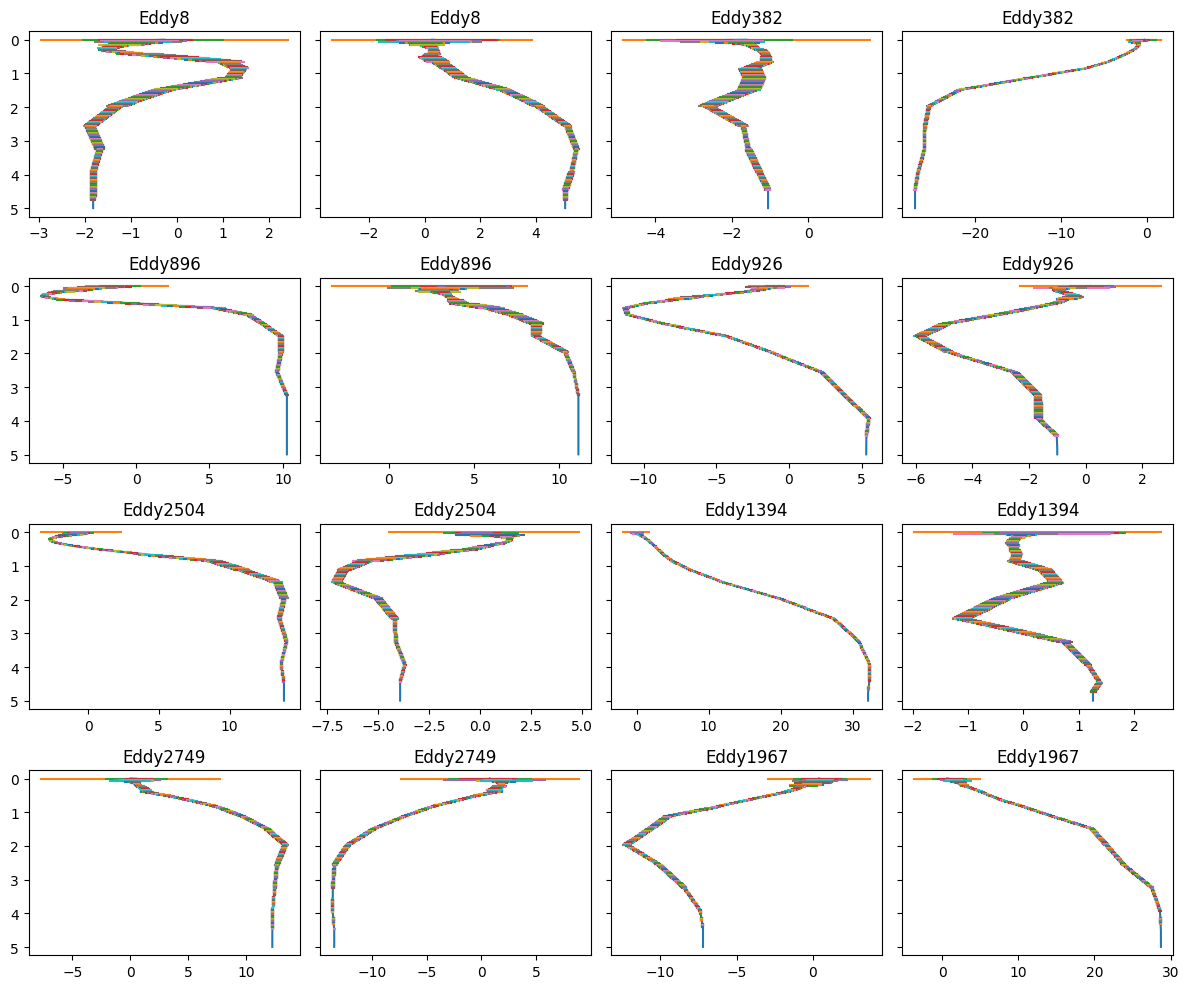

In [19]:
fig, axs = plt.subplots(4,4, figsize=(12,10), sharey=True)
for e, eddy in enumerate(dic_sample.keys()):
    ax0 = axs[e % 4, (e//4)*2]
    ax1 = axs[e % 4, 1+(e//4)*2]

    ax0.set_title(eddy)
    ax1.set_title(eddy)

    x_mean = df_data[f'x_{eddy}_mean']
    x_std = df_data[f'x_{eddy}_std']
    y_mean = df_data[f'y_{eddy}_mean']
    y_std = df_data[f'y_{eddy}_std']

    ax0.plot(x_mean.cumsum(), df_data.index/1000)
    for (r, x, z) in zip(x_std, x_mean.cumsum(), df_data.index/1000):
        ax0.plot([x-r, x+r], [z, z])
    ax1.plot(y_mean.cumsum(), df_data.index/1000)
    for (r, y, z) in zip(y_std, y_mean.cumsum(), df_data.index/1000):
        ax1.plot([y-r, y+r], [z, z])

axs[0,0].invert_yaxis()
plt.tight_layout()


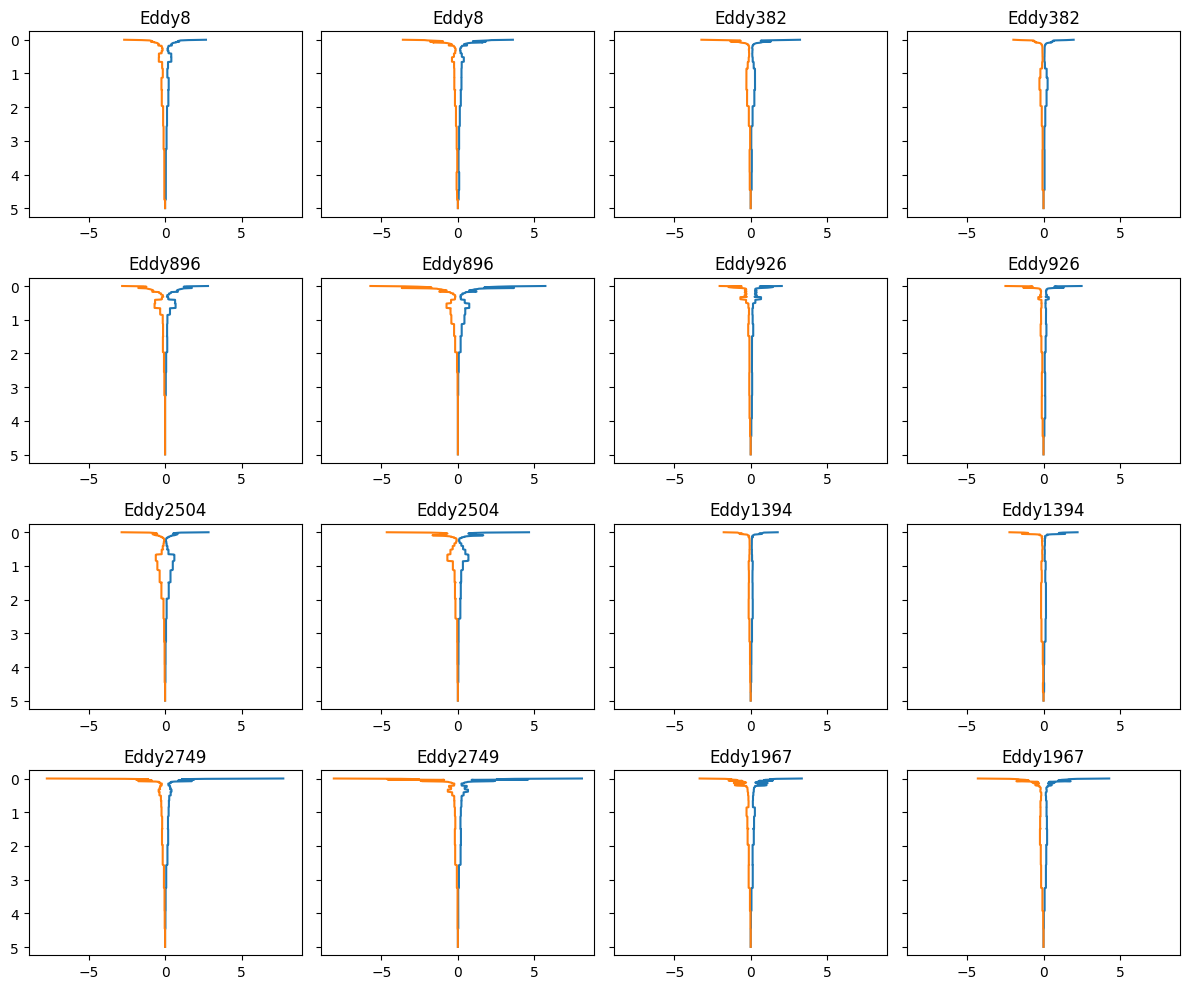

In [20]:
fig, axs = plt.subplots(4,4, figsize=(12,10), sharey=True)
xmax = 0
for e, eddy in enumerate(dic_sample.keys()):
    ax0 = axs[e % 4, (e//4)*2]
    ax1 = axs[e % 4, 1+(e//4)*2]

    ax0.set_title(eddy)
    ax1.set_title(eddy)

    x_mean = df_data[f'x_{eddy}_mean']
    x_std = df_data[f'x_{eddy}_std']
    y_mean = df_data[f'y_{eddy}_mean']
    y_std = df_data[f'y_{eddy}_std']

    ax0.plot(x_std, df_data.index/1000)
    ax0.plot(-x_std, df_data.index/1000)
    ax1.plot(y_std, df_data.index/1000)
    ax1.plot(-y_std, df_data.index/1000)

    xmax = max(xmax, ax0.get_xlim()[1], ax1.get_xlim()[1])
for ax in axs.flat:
    ax.set_xlim(-xmax, xmax)

axs[0,0].invert_yaxis()
plt.tight_layout()


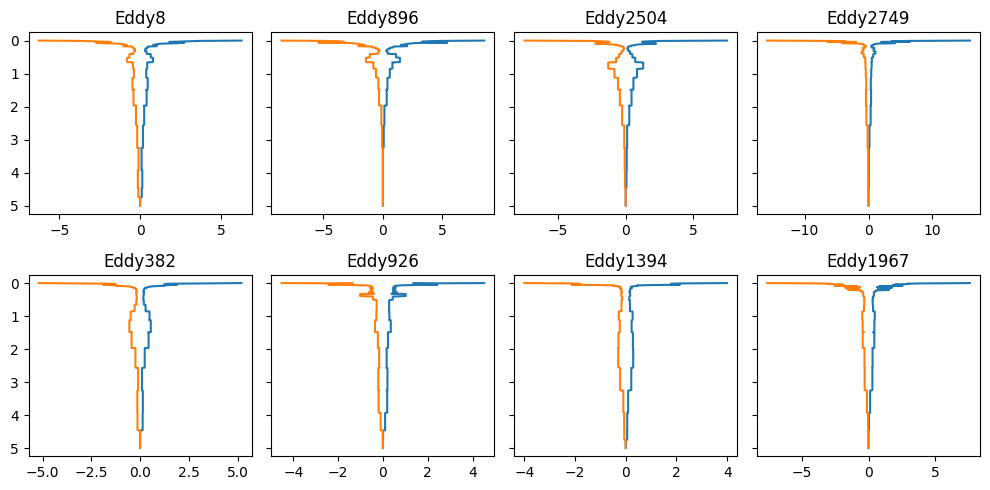

In [21]:
fig, axs = plt.subplots(2, 4, figsize=(10,5), sharey=True)     
for e, eddy in enumerate(dic_sample.keys()):
    ax = axs[e // 4, e % 4]
    ax.set_title(eddy)

    x_mean = df_data[f'x_{eddy}_mean']
    x_std = df_data[f'x_{eddy}_std']
    y_mean = df_data[f'y_{eddy}_mean']
    y_std = df_data[f'y_{eddy}_std']

    ax.plot(x_std+y_std, df_data.index/1000)
    ax.plot(-x_std-y_std, df_data.index/1000)

axs[0,0].invert_yaxis()
plt.tight_layout()


#### Velocity Field

In [22]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
fnumber_old = 0

In [ ]:
eddy = 8
day_idx = 65
r = 140

dic = dic_sample[f'Eddy{eddy}']
day = list(dic.keys())[day_idx]
df = dic[day].copy()
day = int(day[3:])

fname = df_eddies[(df_eddies['ID']==eddy)&(df_eddies['Day']==day)].iloc[0]['fname']

fnumber = fname[-8:-3]
if fnumber != fnumber_old:

    u_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/u_' + fnumber + '.npy')
    v_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/v_' + fnumber + '.npy')
    
    u_raw = np.where(np.abs(u_raw) > 1e30, np.nan, u_raw).astype(float)
    v_raw = np.where(np.abs(v_raw) > 1e30, np.nan, v_raw).astype(float)
    
    with nc.Dataset(fname) as dataset:
        ocean_time = dataset.variables['ocean_time'][:].data / 86400
    fnumber_old = fnumber
t_rel = np.where(ocean_time == day)[0][0]

u_t, v_t = u_raw[:, :, :, t_rel], v_raw[:, :, :, t_rel]

xc_surf, yc_surf = df.iloc[0].x, df.iloc[0].y
ic = np.where(np.abs(x_grid-xc_surf)==np.min(np.abs(x_grid-xc_surf)))[0][0]
jc = np.where(np.abs(y_grid-yc_surf)==np.min(np.abs(y_grid-yc_surf)))[0][0]

x_mask = np.where(np.abs(x_grid - xc_surf) < r)[0]
y_mask = np.where(np.abs(y_grid - yc_surf) < r)[0]

fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].contourf(x_grid[x_mask], -z_r/1000, v_t[x_mask, jc, :].T)
axs[0].plot(df.x, -df.Depth/1000, color='r')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (km)')
axs[0].invert_yaxis()
axs[1].contourf(y_grid[y_mask], -z_r/1000, u_t[ic, y_mask, :].T)
axs[1].plot(df.y, -df.Depth/1000, color='r')
axs[1].set_xlabel('y (km)')

axs[0].plot(x_grid[x_mask], h[x_mask, jc]/1000, 'k')
axs[1].plot(y_grid[y_mask], h[ic, y_mask]/1000, 'k')
ylim0 = axs[0].get_ylim()
ylim1 = axs[1].get_ylim()
axs[0].fill_between(x_grid[x_mask], h[x_mask, jc]/1000, 10, color='k')
axs[1].fill_between(y_grid[y_mask], h[ic, y_mask]/1000, 10, color='k')
axs[0].set_ylim(ylim0)
axs[1].set_ylim(ylim1)

plt.tight_layout()


In [ ]:
sample_eddies

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(12,10), sharey=True)
colors = plt.get_cmap('tab10').colors
fnumber_old = None

for e, (eddy, day_idx) in enumerate(zip(eddy_p, day_idx_p)):
    
    ax0 = axs[e % 4, (e//4)*2]
    ax1 = axs[e % 4, 1+(e//4)*2]
    r = 140

    ax0.set_title(f'Eddy{eddy}, Day {day_idx}')
    ax1.set_title(f'Eddy{eddy}, Day {day_idx}')
    
    dic = dic_sample[f'Eddy{eddy}']
    day = list(dic.keys())[day_idx]
    df = dic[day].copy()
    day = int(day[3:])
    
    fname = df_eddies[(df_eddies['ID']==eddy)&(df_eddies['Day']==day)].iloc[0]['fname']
    
    fnumber = fname[-8:-3]
    if fnumber != fnumber_old:
    
        u_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/u_' + fnumber + '.npy')
        v_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/v_' + fnumber + '.npy')
        
        u_raw = np.where(np.abs(u_raw) > 1e30, np.nan, u_raw).astype(float)
        v_raw = np.where(np.abs(v_raw) > 1e30, np.nan, v_raw).astype(float)
        
        with nc.Dataset(fname) as dataset:
            ocean_time = dataset.variables['ocean_time'][:].data / 86400
        fnumber_old = fnumber
    t_rel = np.where(ocean_time == day)[0][0]
    
    u_t, v_t = u_raw[:, :, :, t_rel], v_raw[:, :, :, t_rel]
    
    xc_surf, yc_surf = df.iloc[0].x, df.iloc[0].y
    ic = np.where(np.abs(x_grid-xc_surf)==np.min(np.abs(x_grid-xc_surf)))[0][0]
    jc = np.where(np.abs(y_grid-yc_surf)==np.min(np.abs(y_grid-yc_surf)))[0][0]
    
    x_mask = np.where(np.abs(x_grid - xc_surf) < r)[0]
    y_mask = np.where(np.abs(y_grid - yc_surf) < r)[0]
    
    # symmetric limits
    vmax_v = np.nanmax(np.abs(v_t[x_mask, jc, :]))
    vmax_u = np.nanmax(np.abs(u_t[ic, y_mask, :]))
    
    # v‐slice
    im0 = ax0.contourf(
        x_grid[x_mask],
        -z_r/1000,
        v_t[x_mask, jc, :].T,
        cmap='coolwarm',
        vmin=-vmax_v,
        vmax=+vmax_v
    )
    ax0.plot(df.x, -df.Depth/1000, color=colors[e])
    ax0.set_xlabel('x (km)')
    ax0.set_ylabel('Depth (km)')
    ax0.plot(x_grid[x_mask], h[x_mask, jc]/1000, 'k')
    ax0.fill_between(x_grid[x_mask], h[x_mask, jc]/1000, 10, color='k')
    ax0.set_ylim(ax0.get_ylim())
    
    # vertical colourbar on the right
    cbar0 = fig.colorbar(
        im0,
        ax=ax0,
        orientation='vertical',  # default but explicit here
        pad=0.02,                # small gap to the right
        shrink=0.8               # scale to fit subplot height
    )
    cbar0.set_label('v (m/s)')
    
    # u‐slice
    im1 = ax1.contourf(
        y_grid[y_mask],
        -z_r/1000,
        u_t[ic, y_mask, :].T,
        cmap='coolwarm',
        vmin=-vmax_u,
        vmax=+vmax_u
    )
    ax1.plot(df.y, -df.Depth/1000, color=colors[e])
    ax1.set_xlabel('y (km)')
    ax1.plot(y_grid[y_mask], h[ic, y_mask]/1000, 'k')
    ax1.fill_between(y_grid[y_mask], h[ic, y_mask]/1000, 10, color='k')
    ax1.set_ylim(0, 5)
    
    # vertical colourbar on the right
    cbar1 = fig.colorbar(
        im1,
        ax=ax1,
        orientation='vertical',
        pad=0.02,
        shrink=0.8
    )
    cbar1.set_label('u (m/s)')

# invert y once at the end
axs[0,0].invert_yaxis()
plt.tight_layout()
plt.show()
